In [1]:
import pandas as pd
import numpy as np
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = kagglehub.dataset_download("blastchar/telco-customer-churn")
print("Path to dataset: ", path)

Path to dataset:  /Users/alejandrodiazalvarado/.cache/kagglehub/datasets/blastchar/telco-customer-churn/versions/1


In [3]:
route = "/Users/alejandrodiazalvarado/.cache/kagglehub/datasets/blastchar/telco-customer-churn/versions/1"

In [4]:
df = pd.read_csv(route+"/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


----------------------------------
Exploratory Data Analysis (EDA)
----------------------------------

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
#Check null values
print(df[df.isnull().any(axis=1)].count())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [7]:
#Check number of churn 
print(df['Churn'].value_counts())

Churn
No     5174
Yes    1869
Name: count, dtype: int64


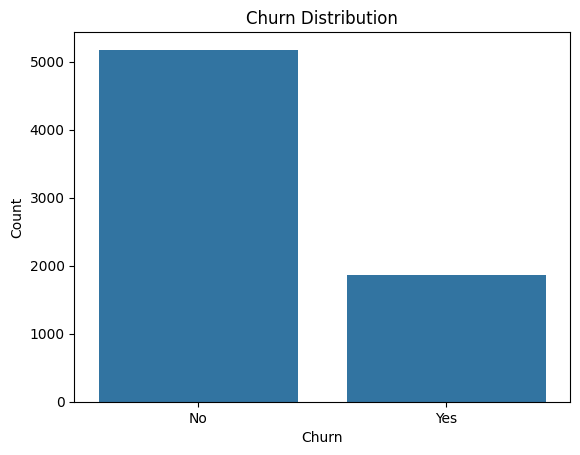

In [8]:
#Churn graph
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

In [9]:
#Check TotalCharges values
print(df['TotalCharges'].describe())

count     7043
unique    6531
top           
freq        11
Name: TotalCharges, dtype: object


In [10]:
#Check for non-numeric values in TotalCharges
non_numeric_total_charges = df[pd.to_numeric(df['TotalCharges'], errors='coerce').isna()]
print(non_numeric_total_charges) 

      customerID  gender  SeniorCitizen Partner Dependents  tenure  \
488   4472-LVYGI  Female              0     Yes        Yes       0   
753   3115-CZMZD    Male              0      No        Yes       0   
936   5709-LVOEQ  Female              0     Yes        Yes       0   
1082  4367-NUYAO    Male              0     Yes        Yes       0   
1340  1371-DWPAZ  Female              0     Yes        Yes       0   
3331  7644-OMVMY    Male              0     Yes        Yes       0   
3826  3213-VVOLG    Male              0     Yes        Yes       0   
4380  2520-SGTTA  Female              0     Yes        Yes       0   
5218  2923-ARZLG    Male              0     Yes        Yes       0   
6670  4075-WKNIU  Female              0     Yes        Yes       0   
6754  2775-SEFEE    Male              0      No        Yes       0   

     PhoneService     MultipleLines InternetService       OnlineSecurity  ...  \
488            No  No phone service             DSL                  Yes  ... 

In [11]:
#Convert TotalCharges to numeric, forcing errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.loc[df['TotalCharges'].isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [12]:
#Now, fill the NaN values in TotalCharges with the mean of the column
mean_total_charges = df['TotalCharges'].mean()
df.fillna({'TotalCharges': mean_total_charges}, inplace=True)


In [13]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [14]:
#Check for duplicates
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

Duplicate rows: 0


In [15]:
#Check unique values
for col in df.columns:
    print(f"Unique values in {col}: {df[col].unique()}")

Unique values in customerID: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Unique values in gender: ['Female' 'Male']
Unique values in SeniorCitizen: [0 1]
Unique values in Partner: ['Yes' 'No']
Unique values in Dependents: ['No' 'Yes']
Unique values in tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
Unique values in PhoneService: ['No' 'Yes']
Unique values in MultipleLines: ['No phone service' 'No' 'Yes']
Unique values in InternetService: ['DSL' 'Fiber optic' 'No']
Unique values in OnlineSecurity: ['No' 'Yes' 'No internet service']
Unique values in OnlineBackup: ['Yes' 'No' 'No internet service']
Unique values in DeviceProtection: ['No' 'Yes' 'No internet service']
Unique values in TechSupport: ['No' 'Yes' 'No internet service']
Unique values in StreamingTV: ['No' '

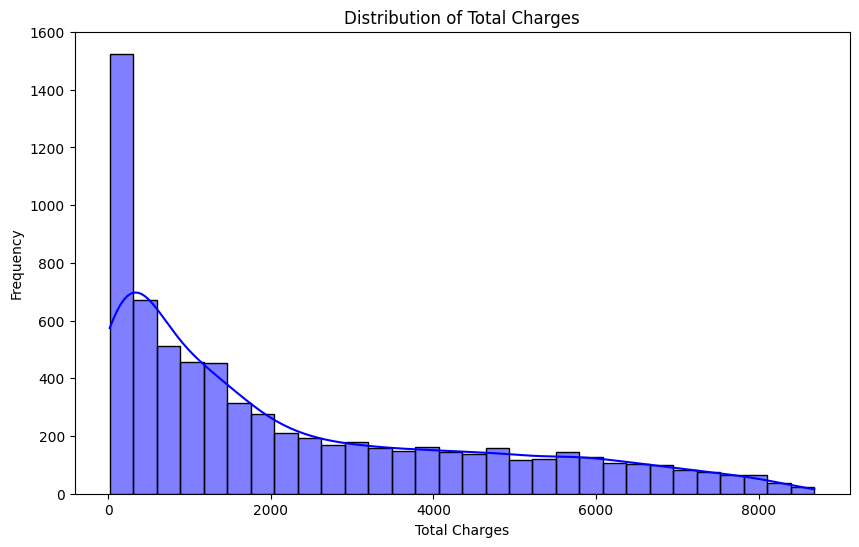

In [16]:
#Distribution of total charges
plt.figure(figsize=(10, 6))
sns.histplot(df['TotalCharges'], bins=30, kde=True, color='blue')
plt.title('Distribution of Total Charges')
plt.xlabel('Total Charges')
plt.ylabel('Frequency')
plt.show()

In [18]:
Q1 = df['TotalCharges'].quantile(0.25)
Q3 = df['TotalCharges'].quantile(0.75)
IQR = Q3 - Q1
print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
out = df[(df['TotalCharges'] < lower_bound)]
print(out)

Q1: 402.225, Q3: 3786.6, IQR: 3384.375
Lower Bound: -4674.3375, Upper Bound: 8863.1625
Empty DataFrame
Columns: [customerID, gender, SeniorCitizen, Partner, Dependents, tenure, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, Churn]
Index: []

[0 rows x 21 columns]


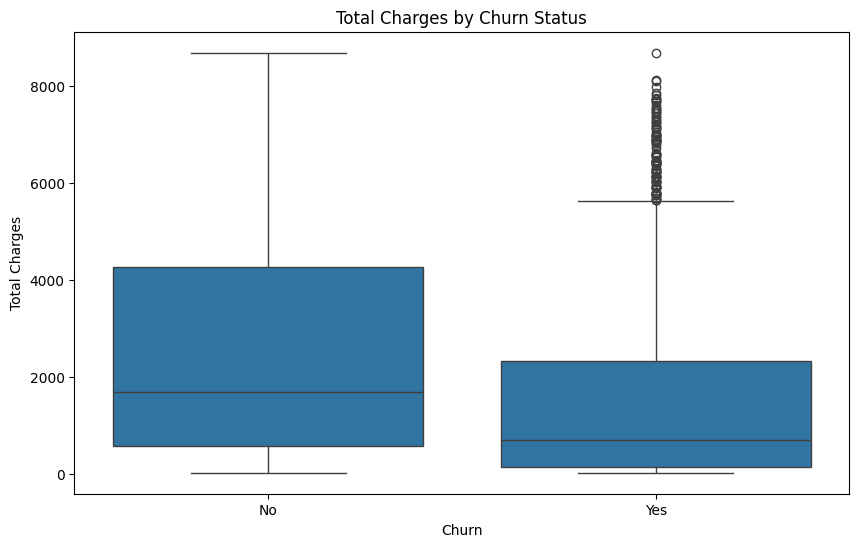

In [20]:
#Distribution of total charges by churn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='TotalCharges', data=df)   
plt.title('Total Charges by Churn Status')
plt.xlabel('Churn')
plt.ylabel('Total Charges')
plt.show()

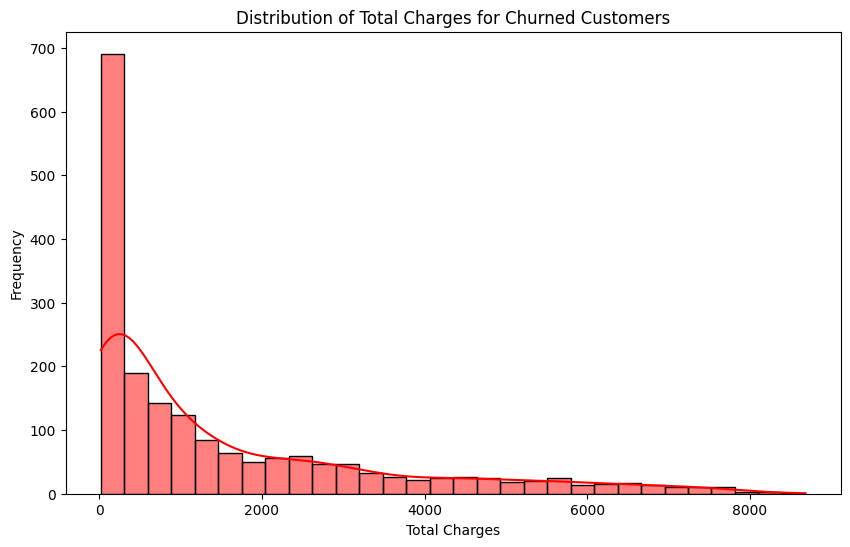

In [21]:
#Distribution of total charges by churn = Yes
plt.figure(figsize=(10, 6))
sns.histplot(df[df['Churn'] == 'Yes']['TotalCharges'], bins=30, kde=True, color='red')
plt.title('Distribution of Total Charges for Churned Customers')
plt.xlabel('Total Charges')
plt.ylabel('Frequency')
plt.show()

------------------------------
Data Manipulation
------------------------------

In [51]:
#Copy the DataFrame
df_copy = df.copy()


In [52]:
#Drop customerID column
df_copy.drop(columns=['customerID'], inplace=True)

In [55]:
#unique value for object columns
for col in df_copy.select_dtypes(include=['object']).columns:
    print(f"Unique values in {col}: {df_copy[col].nunique()}")

Unique values in gender: 2
Unique values in Partner: 2
Unique values in Dependents: 2
Unique values in PhoneService: 2
Unique values in MultipleLines: 3
Unique values in InternetService: 3
Unique values in OnlineSecurity: 3
Unique values in OnlineBackup: 3
Unique values in DeviceProtection: 3
Unique values in TechSupport: 3
Unique values in StreamingTV: 3
Unique values in StreamingMovies: 3
Unique values in Contract: 3
Unique values in PaperlessBilling: 2
Unique values in PaymentMethod: 4
Unique values in Churn: 2


In [ ]:
#Transform object columns to number
cols_2_transform = ["gender", "Partner", "Dependents", "PhoneService", "PaperlessBilling", "Churn"]
for col in cols_2_transform:
    df_copy[col] = df_copy[col].map({"Yes": 1, "No": 0, "Male": 1, "Female": 0})


In [58]:
cols_3_transform = ["MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract", "PaymentMethod"]
df_copy = pd.get_dummies(df_copy, columns=cols_3_transform, drop_first=True)

In [60]:
#Transform bool columns to int
for col in df_copy.select_dtypes(include=[bool]).columns:
    df_copy[col] = df_copy[col].astype(int)

In [61]:
df_copy.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,0,0,0,0,0,1,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,1,0,0,0,0,1,0,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,...,0,0,0,0,0,0,0,0,1,0


-----------------------------------------------------------
Feature Selection 
-----------------------------------------------------------

Selected features based on ANOVA F-value:
 Index(['tenure', 'InternetService_Fiber optic',
       'OnlineSecurity_No internet service',
       'OnlineBackup_No internet service',
       'DeviceProtection_No internet service',
       'TechSupport_No internet service', 'StreamingTV_No internet service',
       'StreamingMovies_No internet service', 'Contract_Two year',
       'PaymentMethod_Electronic check'],
      dtype='object')


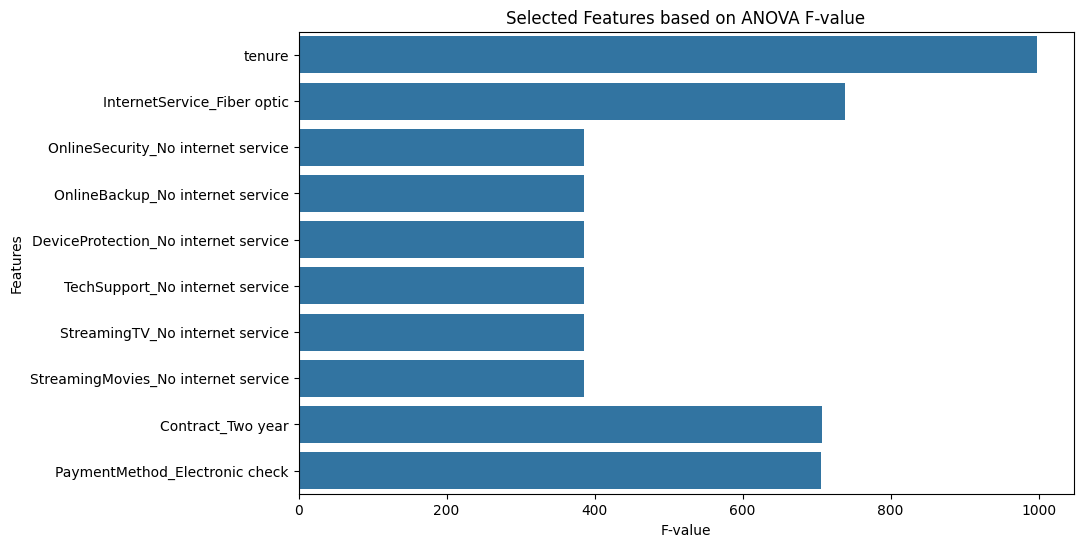

In [67]:
#feature selection
from sklearn.feature_selection import SelectKBest, f_classif
X = df_copy.drop('Churn', axis=1)
y = df_copy['Churn']
selector = SelectKBest(score_func=f_classif, k=10)
selector.fit(X, y)
# Get the selected feature indices
selected_indices = selector.get_support(indices=True)
# Get the selected feature names
selected_features = X.columns[selected_indices]
print("Selected features based on ANOVA F-value:\n", selected_features)
#Visualize the selected features
plt.figure(figsize=(10, 6))
sns.barplot(x=selector.scores_[selected_indices], y=selected_features)
plt.title('Selected Features based on ANOVA F-value')
plt.xlabel('F-value')
plt.ylabel('Features')
plt.show()

-------------------------------------
Comparing Models
--------------------

In [70]:
#Random Forest Algorithm
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
#Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix
y_pred = rf.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Confusion Matrix:
 [[944  92]
 [197 176]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1036
           1       0.66      0.47      0.55       373

    accuracy                           0.79      1409
   macro avg       0.74      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409



In [75]:
#Linear Regression for predicting Churn
from sklearn.linear_model import LogisticRegression
log_reg_model = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
log_reg_model.fit(X_train, y_train)
#Evaluate the Logistic Regression model
y_pred_log_reg = log_reg_model.predict(X_test)
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log_reg))
print("Logistic Regression Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log_reg))


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.68      0.59      0.63       373

    accuracy                           0.82      1409
   macro avg       0.77      0.74      0.76      1409
weighted avg       0.81      0.82      0.81      1409

Logistic Regression Confusion Matrix:
 [[932 104]
 [153 220]]


Pipeline

In [76]:
#Comparing models
from sklearn.metrics import accuracy_score
rf_accuracy = accuracy_score(y_test, y_pred)
log_reg_model_accuracy = accuracy_score(y_test, y_pred_log_reg)
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")
print(f"Logistic Regression Accuracy: {log_reg_model_accuracy:.2f}")


Random Forest Accuracy: 0.79
Logistic Regression Accuracy: 0.82


--------------------------------
Models using future selection
--------------------------------

In [78]:
#Keep future selection columns
X_selected = X[selected_features]
#Split the data
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_selected, y, test_size=0.2, random_state=42)
#Train Random Forest on selected features
rf_selected = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selected.fit(X_train_selected, y_train_selected)
#Evaluate the model on selected features
y_pred_selected = rf_selected.predict(X_test_selected)
print("Confusion Matrix for Selected Features:\n", confusion_matrix(y_test_selected, y_pred_selected))
print("Classification Report for Selected Features:\n", classification_report(y_test_selected, y_pred_selected))

Confusion Matrix for Selected Features:
 [[908 128]
 [159 214]]
Classification Report for Selected Features:
               precision    recall  f1-score   support

           0       0.85      0.88      0.86      1036
           1       0.63      0.57      0.60       373

    accuracy                           0.80      1409
   macro avg       0.74      0.73      0.73      1409
weighted avg       0.79      0.80      0.79      1409



In [79]:
#Now use Logistic Regression on selected features
log_reg_model_selected = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
log_reg_model_selected.fit(X_train_selected, y_train_selected)
#Evaluate the Logistic Regression model on selected features
y_pred_log_reg_selected = log_reg_model_selected.predict(X_test_selected)
print("Logistic Regression Classification Report for Selected Features:\n", classification_report(y_test_selected, y_pred_log_reg_selected))
print("Logistic Regression Confusion Matrix for Selected Features:\n", confusion_matrix(y_test_selected, y_pred_log_reg_selected))

Logistic Regression Classification Report for Selected Features:
               precision    recall  f1-score   support

           0       0.84      0.92      0.88      1036
           1       0.69      0.51      0.59       373

    accuracy                           0.81      1409
   macro avg       0.76      0.71      0.73      1409
weighted avg       0.80      0.81      0.80      1409

Logistic Regression Confusion Matrix for Selected Features:
 [[951  85]
 [183 190]]


---
Now, we're going to apply SMOTE
---

In [ ]:
#Applying smoting to the dataset
from imblearn.over_sampling import SMOTE


In [81]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_selected, y_train_selected)


In [83]:
print(y_resampled.value_counts())

Churn
0    4138
1    4138
Name: count, dtype: int64


In [84]:
#random forest on resampled data
rf_resampled = RandomForestClassifier(n_estimators=100, random_state=42)
rf_resampled.fit(X_resampled, y_resampled)
#Evaluate the Random Forest model on resampled data
y_pred_resampled = rf_resampled.predict(X_test_selected)
print("Confusion Matrix for Resampled Data:\n", confusion_matrix(y_test_selected, y_pred_resampled))
print("Classification Report for Resampled Data:\n", classification_report(y_test_selected, y_pred_resampled))


Confusion Matrix for Resampled Data:
 [[706 330]
 [ 73 300]]
Classification Report for Resampled Data:
               precision    recall  f1-score   support

           0       0.91      0.68      0.78      1036
           1       0.48      0.80      0.60       373

    accuracy                           0.71      1409
   macro avg       0.69      0.74      0.69      1409
weighted avg       0.79      0.71      0.73      1409



In [85]:
#Linear Regression on resampled data
log_reg_model_resampled = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
log_reg_model_resampled.fit(X_resampled, y_resampled)
#Evaluate the Logistic Regression model on resampled data
y_pred_log_reg_resampled = log_reg_model_resampled.predict(X_test_selected)
print("Logistic Regression Classification Report for Resampled Data:\n", classification_report(y_test_selected, y_pred_log_reg_resampled))
print("Logistic Regression Confusion Matrix for Resampled Data:\n", confusion_matrix(y_test_selected, y_pred_log_reg_resampled))


Logistic Regression Classification Report for Resampled Data:
               precision    recall  f1-score   support

           0       0.92      0.69      0.79      1036
           1       0.49      0.83      0.62       373

    accuracy                           0.73      1409
   macro avg       0.71      0.76      0.70      1409
weighted avg       0.81      0.73      0.74      1409

Logistic Regression Confusion Matrix for Resampled Data:
 [[718 318]
 [ 64 309]]


----
Comparing the models with diferent variables
---

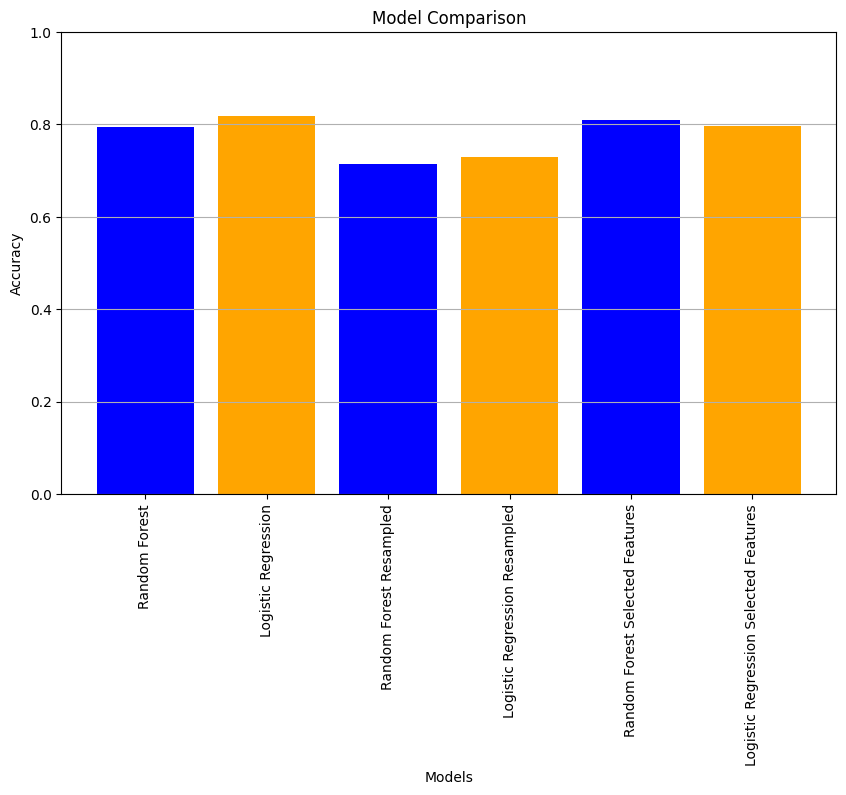

In [89]:
#Graph models with diferent variables

def plot_model_comparison(models, accuracies):
    plt.figure(figsize=(10, 6))
    plt.bar(models, accuracies, color=['blue', 'orange'])
    plt.title('Model Comparison')
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.xticks(rotation=90)
    plt.grid(axis='y')
    plt.show()

#Model accuracies
models = ['Random Forest', 'Logistic Regression', 'Random Forest Resampled', 'Logistic Regression Resampled', 'Random Forest Selected Features', 'Logistic Regression Selected Features']
accuracies = [
    rf_accuracy,
    log_reg_model_accuracy,
    accuracy_score(y_test_selected, y_pred_resampled),
    accuracy_score(y_test_selected, y_pred_log_reg_resampled),
    accuracy_score(y_test_selected, y_pred_log_reg_selected),
    accuracy_score(y_test_selected, y_pred_selected)
]
plot_model_comparison(models, accuracies)
